# Chapter 3 : Exercise

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser = 'auto')
print(mnist.data.shape, mnist.target.shape)  # should be (70000, 784), (70000,)


(70000, 784) (70000,)


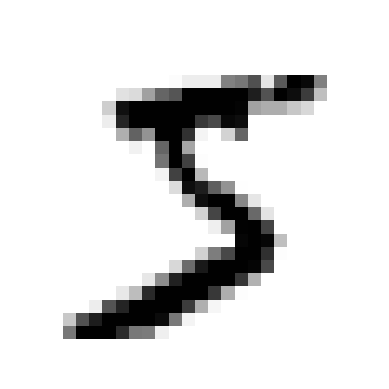

In [4]:
def plot_mnist_image(image):
    image = image.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

plot_mnist_image(mnist.data[0])

## 1. An MNIST Classifier With Over 97% Accuracy
Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


In [6]:
X_train, X_test, y_train, y_test = mnist.data[:60000], mnist.data[60000:], mnist.target[:60000], mnist.target[60000:]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
acc = knn_clf.score(X_test, y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.9688


try using GridSearch on small samples

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
}
grid_search = GridSearchCV(knn_clf, param_grid, cv=5,)
grid_search.fit(X_train[:10000], y_train[:10000])
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation score: 0.94


In [11]:
print("Best estimator:")  
print(grid_search.best_estimator_)

Best estimator:
KNeighborsClassifier(n_neighbors=4, weights='distance')


In [10]:
grid_search.best_estimator_.fit(X_train, y_train)
acc = grid_search.best_estimator_.score(X_test, y_test)
print(f"Test set accuracy: {acc}")

Test set accuracy: 0.9714


## 2. Data Augmentation
Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [12]:
from scipy.ndimage import shift
def shift_image(image, direction):
    if direction == 'left':
        return shift(image, [0, -1], cval=0).flatten()
    elif direction == 'right':
        return shift(image, [0, 1], cval=0).flatten()
    elif direction == 'up':
        return shift(image, [-1, 0], cval=0).flatten()
    elif direction == 'down':
        return shift(image, [1, 0], cval=0).flatten()
    else:
        raise ValueError("Direction must be one of: 'left', 'right', 'up', 'down'")

In [13]:
X_train_augmented = []
y_train_augmented = []
for image,label in zip(X_train,y_train):
    X_train_augmented.append(image)
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image.reshape(28,28), 'left'))
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image.reshape(28,28), 'right'))
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image.reshape(28,28), 'up'))
    y_train_augmented.append(label)
    X_train_augmented.append(shift_image(image.reshape(28,28), 'down'))
    y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

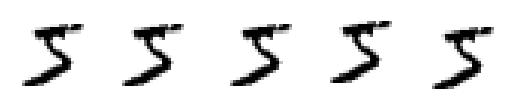

In [14]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_mnist_image(X_train_augmented[i])

In [15]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train_augmented, y_train_augmented)
acc = knn_clf.score(X_test, y_test)

In [16]:
print(acc)

0.9763


## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns.

In [17]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [18]:
train_data, test_data = load_titanic_data()

Overview of the data

In [19]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [22]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

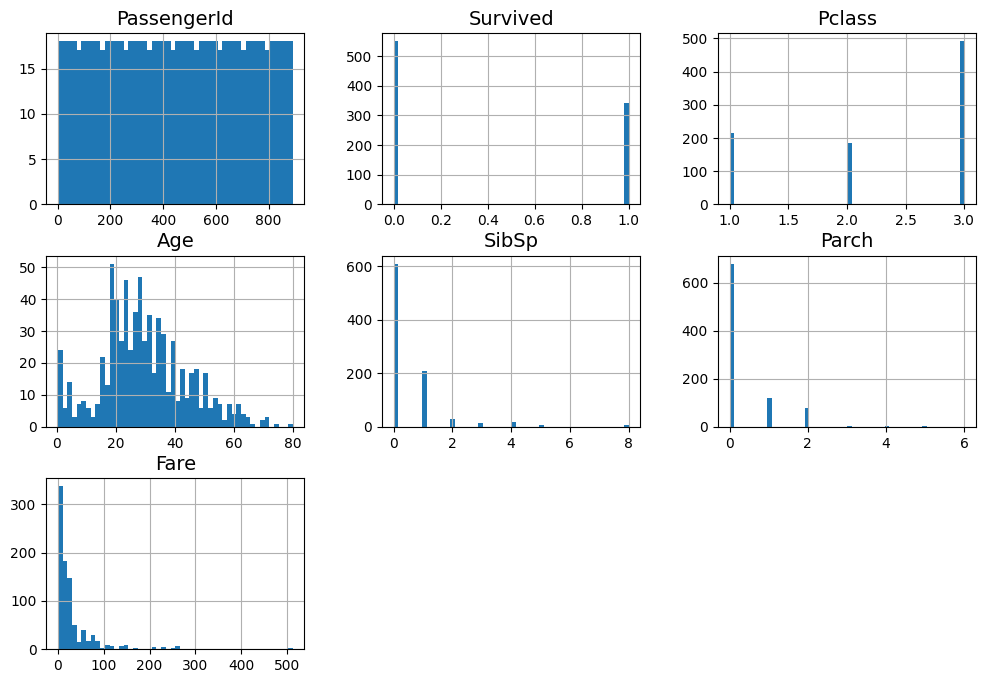

In [23]:
train_data.hist(figsize=(12, 8), bins=50)

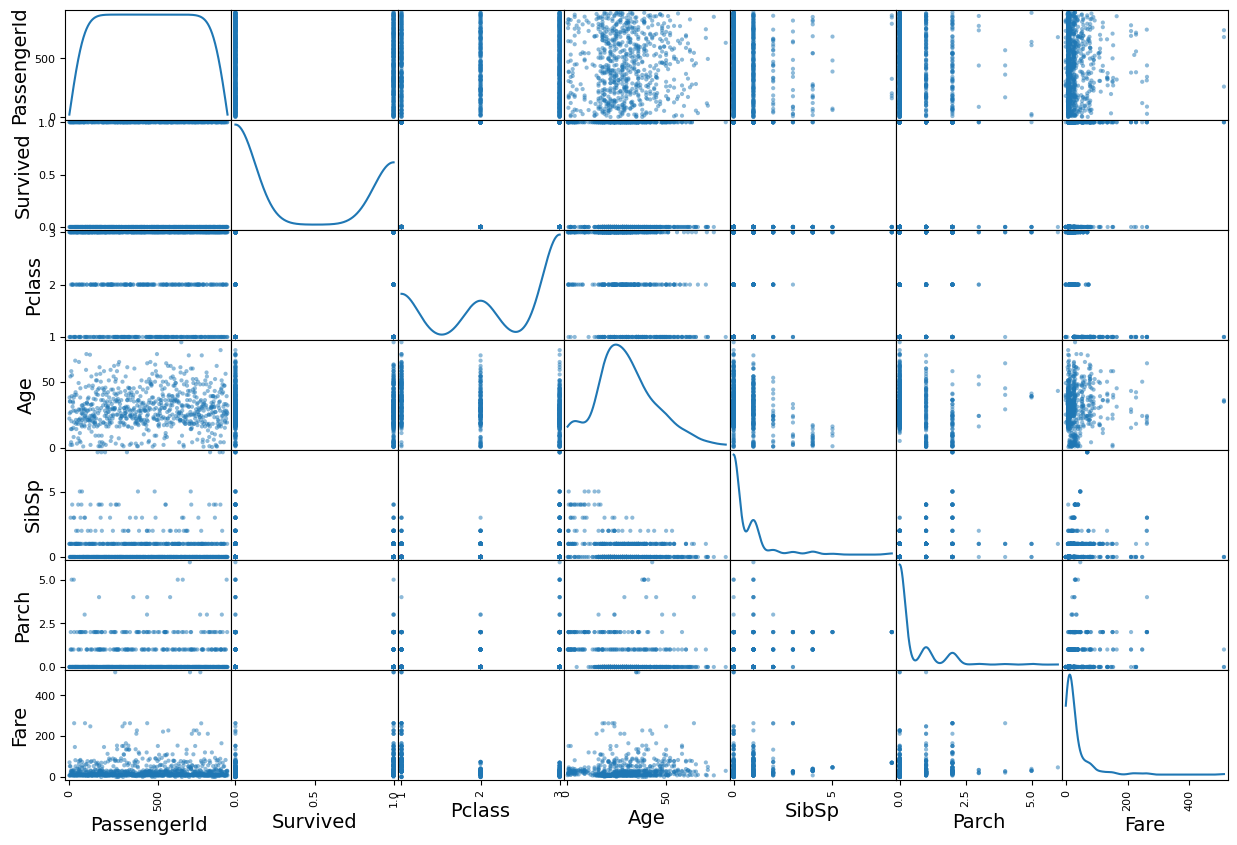

In [24]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_data, figsize=(15, 10), diagonal='kde')
plt.show()

Preprocessing the data

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [26]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(sparse_output=False)),
])

In [30]:
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

pre_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [31]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

In [32]:
X_train = pre_pipeline.fit_transform(X)

In [33]:
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

create a train, test split

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.2, random_state=42)

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
log_reg_score = log_reg.score(X_valid, y_valid)

In [37]:
from sklearn.model_selection import cross_val_score

log_reg_cross_val_scores = cross_val_score(log_reg, X_train, y_train, cv=5)

In [38]:
log_reg_cross_val_scores.mean()

0.7934994582881906

In [39]:
y_pred_log_reg = log_reg.predict(X_valid)

In [40]:
from sklearn.metrics import accuracy_score
log_reg_acc = accuracy_score(y_valid, y_pred_log_reg)
print(log_reg_acc)

0.7988826815642458


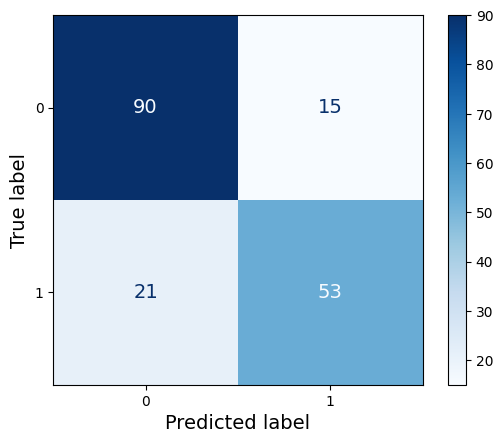

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, y_pred_log_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf_score = forest_clf.score(X_valid, y_valid)


In [101]:
forest_clf_score

0.8212290502793296

In [102]:
y_pred_forest = forest_clf.predict(X_valid)

In [103]:
forest_acc = accuracy_score(y_valid, y_pred_forest)
print(forest_acc)

0.8212290502793296


In [104]:
forest_cross_val_scores = cross_val_score(forest_clf, X_train, y_train, cv=5)
forest_cross_val_scores.mean()

0.7935782527331823

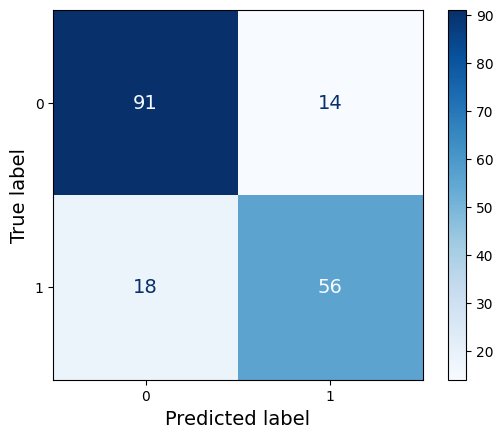

In [49]:
cm = confusion_matrix(y_valid, y_pred_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
forest_cross_val_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_cross_val_scores.mean()

0.8019757433489829

## SVC

In [ ]:
from sklearn.svm import SVC


svc_clf = SVC(kernel='rbf', C=1.0, gamma='scale')
svc_clf.fit(X_train, y_train)
svc_score = svc_clf.score(X_valid, y_valid)

In [52]:
svc_cross_val_scores = cross_val_score(svc_clf, X_train, y_train, cv=5)
svc_cross_val_scores.mean()

0.8229882793263075

In [53]:
y_pred_svc = svc_clf.predict(X_valid)

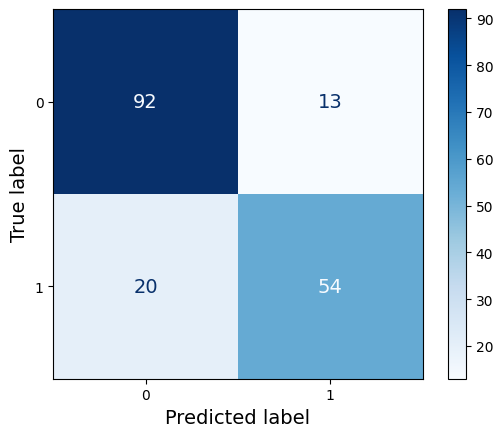

In [54]:
cm = confusion_matrix(y_valid, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Compare 3 model 

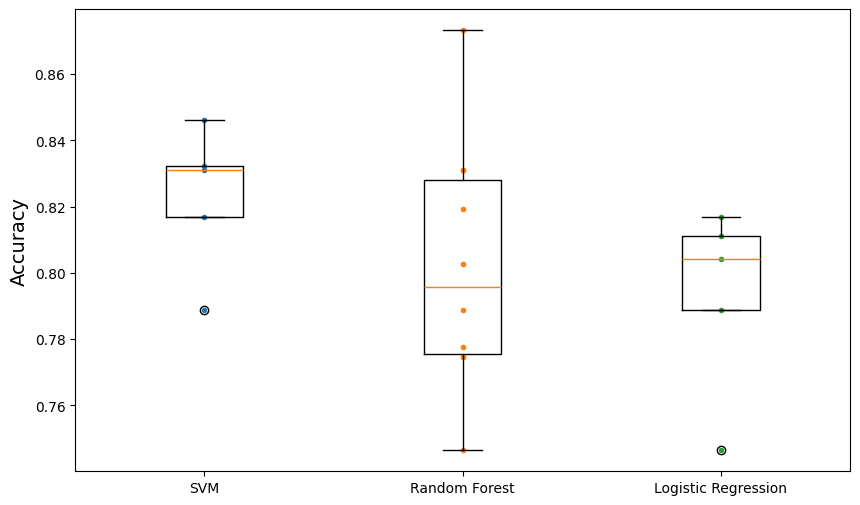

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1]*len(svc_cross_val_scores), svc_cross_val_scores, ".")
plt.plot([2]*len(forest_cross_val_scores), forest_cross_val_scores, ".")
plt.plot([3]*len(log_reg_cross_val_scores), log_reg_cross_val_scores, ".")
plt.boxplot([svc_cross_val_scores, forest_cross_val_scores, log_reg_cross_val_scores], labels=("SVC", "Random Forest", "Logistic Regression"))
plt.ylabel("Accuracy")
plt.show() 

# Try Gridsearch on SVC

In [56]:
from sklearn.model_selection import GridSearchCV
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale','auto'],
    'kernel': ['rbf', 'linear'],
}
grid_search = GridSearchCV(svc_clf, svc_param_grid, cv=5)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']})

In [62]:
grid_search.best_score_

0.8286023835319611

In [88]:
best_estimator = grid_search.best_estimator_
svc_clf_best = SVC(kernel=best_estimator.kernel, C=best_estimator.C, gamma=best_estimator.gamma)
svc_clf_best.fit(X_train, y_train)
svc_acc = svc_clf_best.score(X_valid, y_valid)

In [90]:
svc_acc

0.8156424581005587

# try on the test data

In [91]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [92]:
dummy_test_data = pre_pipeline.transform(test_data)

In [93]:
dummy_test_data

array([[ 0.39488661, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.35550905,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.50825596, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.70228579, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [-0.10463705, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [-0.10463705,  0.43279337,  0.76762988, ...,  1.        ,
         0.        ,  0.        ]])

In [94]:
y = svc_clf_best.predict(dummy_test_data)

In [95]:
y

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [96]:
submission = pd.DataFrame({
    "PassengerId": test_data.index,
    "Survived": y
})

In [97]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [106]:
submission.to_csv("submission.csv", index=False)